# MADCAT

## Subnet 129.206.218.0/24

## Geolocation

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import pycountry
import matplotlib.dates as mdates
import time
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("./data/Attacks from Countries.csv")

exception = {
    "Russia": "Russian Federation",
    "South Korea": "Korea, Republic of",
    "Palestine": "Palestine, State of",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Brunei": "Brunei Darussalam",
    "DR Congo": "Congo, The Democratic Republic of the",
    "Ivory Coast": "Côte d'Ivoire",
    "Sint Maarten": "Sint Maarten (Dutch part)"
    
    
}

country_name = {}
for country in pycountry.countries:
    country_name[country.name] = country.alpha_3
    if hasattr(country, 'common_name'):
        country_name[country.common_name] = country.alpha_3
    if hasattr(country, 'official_name'):
        country_name[country.official_name] = country.alpha_3
    if hasattr(country, 'numeric'):
        country_name[country.numeric] = country.alpha_3
codes = []
for country in df["geoip.country_name.keyword: Descending"]:
    
    code = country_name.get(country, 'Unknown code')
    if code == 'Unknown code':
        if country in exception:
            codes.append(country_name.get(exception.get(country), 'Unknown code'))
        else:
            print(country)
            codes.append(code)
    else:
        codes.append(code)
df["iso_a3"] = codes
df.head()

,geoip.country_name.keyword: Descending,Count,iso_a3
0,United States,10014,USA
1,Germany,6171,DEU
2,China,2032,CHN
3,United Kingdom,1048,GBR
4,France,779,FRA


In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world = pd.merge(world, df, on='iso_a3')
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,geoip.country_name.keyword: Descending,Count
0,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",Canada,258
1,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",United States,10014
2,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...,Indonesia,3
3,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...,Argentina,3
4,142257519,Europe,Russia,RUS,3745000.0,"(POLYGON ((178.7253 71.0988, 180.0000000000001...",Russia,76


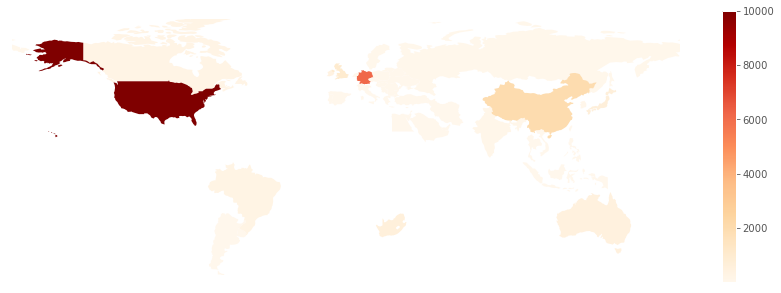

In [4]:
fig, ax = plt.subplots(figsize = (15, 5))
world.plot(ax=ax, column="Count", cmap='OrRd', legend=True)
ax.set_facecolor('white')
# geo_df.plot(ax=ax)

plt.xticks([])
plt.yticks([])
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

fig.savefig("madcat-overview-map.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

## Protocol Distribution

In [5]:
df = pd.read_csv("./data/Protocol used.csv")
df.Count = df.Count.str.replace(',', '').astype(int)
df["timestamp per 12 hours"] = pd.to_datetime(df["timestamp per 12 hours"])
df.head()

,Top 999 unusual terms in proto.keyword,timestamp per 12 hours,Count
0,ICMP,2021-10-29 00:00:00,2
1,ICMP,2021-10-29 12:00:00,16
2,ICMP,2021-10-30 00:00:00,9
3,ICMP,2021-10-30 12:00:00,14
4,ICMP,2021-10-31 00:00:00,18


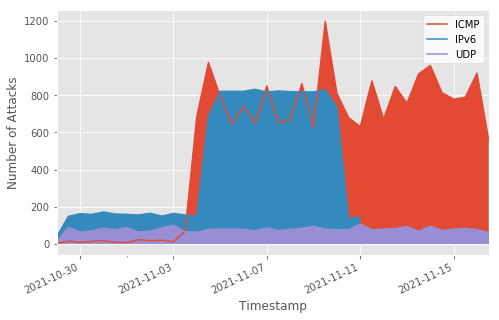

In [7]:
fig, ax = plt.subplots(figsize = (8,5))

for k, d in df.groupby('Top 999 unusual terms in proto.keyword'):
    x = d['timestamp per 12 hours'].to_numpy()
    y = d['Count'].to_numpy()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    
    #ax.scatter(x,y)
    ax.plot(x,y, label=k)
    ax.fill_between(x, y)


fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df["timestamp per 12 hours"].min()
datemax = df["timestamp per 12 hours"].max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='upper right',frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("madcat-protocol-usage.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## Suricata

In [5]:
df = pd.read_csv("./data/Suricata Alert Category Histogram 419.csv")
df.Attacks = df.Attacks.str.replace(',', '').astype(int)
df.Timestamp = pd.to_datetime(df.Timestamp)
#df = df.sort_values(by=["alert", "Timestamp"])
df.head()

,alert.category.keyword: Descending,Timestamp,Attacks
0,Attempted Administrator Privilege Gain,2021-11-16 12:00:00,22730
1,Attempted Administrator Privilege Gain,2021-11-18 12:00:00,12084
2,Attempted Administrator Privilege Gain,2021-11-19 00:00:00,25681
3,Attempted Administrator Privilege Gain,2021-11-24 00:00:00,4433
4,Attempted Administrator Privilege Gain,2021-11-24 12:00:00,12073


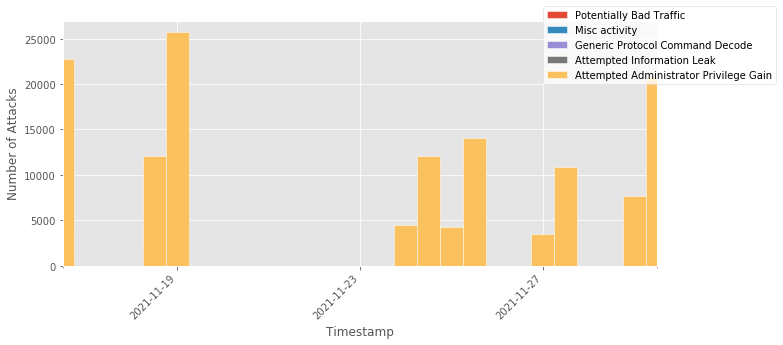

In [6]:
fig, ax = plt.subplots(figsize = (15,5))

x_pos = [i for i, _ in enumerate(df.groupby("Timestamp"))]

bottoms=[]
for idx, (k, d) in reversed(list(enumerate(df.groupby("alert.category.keyword: Descending")))):
    x = d["Timestamp"]
    y = d["Attacks"]
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    
    if idx == 4:
        ax.bar(x, y, 0.5, edgecolor='white',label=k)
    else:
        ax.bar(x, y, 0.5,bottom=bottoms[idx-3] ,edgecolor='white',label=k)
    
    bottoms.append(y.to_numpy())

fig.autofmt_xdate()
plt.ylabel("Number of Attacks")
plt.xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.9), frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.35)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("madcat-suricata-alerts.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## Subnet Eduroam